# Исследование тарифных планов
В нашем распоряжении данные компании «Мегалайн» — федерального оператора сотовой связи. Мы имеем данные небольшой выборки клиентов - 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф приносит больше денег, для дальнейшей корректировки рекламного бюджета.

## Изучение данных из файлов

Загрузим бибилиотеки 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

Посмотрим на информацию о таблицах и выведем первые строки

In [2]:
users = pd.read_csv('/datasets/users.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [3]:
calls = pd.read_csv('/datasets/calls.csv')
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
messages = pd.read_csv('/datasets/messages.csv')
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [5]:
internet = pd.read_csv('/datasets/internet.csv')
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод

Мы видим довольно чистые двнные, пропуски в таблице со звонками - это пропущенные звонки, а в дате прекращения пользования тарифом означают, что тарифом еще пользуются. Нужно перевести даты из обьекта в дэйттайм, а также в таблице с интернетом есть лишний стобец с индексами от которого следует избавится.

## Предобработка данных

### Изменение типов данных и работа с ошибками

Уберем лишний столбец с индексами из таблицы internet

In [7]:
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Поменяем формат в колонках с датами на datetime

In [8]:
# воспользуемся методом to_datetime для нужных колонок
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
# проверим результат 
users.info()

# P.S. пробовал такую функцию, но результат почему то не сохранялся за ее пределами
# for i in (users['churn_date'], users['reg_date'], calls['call_date'], messages['message_date'], internet['session_date']):
#     i = pd.to_datetime(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Вывод

Мы исправили ошибку в таблице с интернетом и поменяли тип данных в столбцах с датами, подготовив двнные к дальнейшей работе.

## Расчет данных по пользователям

### Расчет звонков

Округлим данные о звонках до минут

In [56]:
calls['duration'] = np.ceil(calls['duration'])

Добавим столбец с месяцем звонка

In [10]:
calls['month'] = calls['call_date'].dt.month

Создадим таблицу с кол-вом звонков по месяцам

In [11]:
calls_count = calls.pivot_table(
    index='user_id',
    columns='month',
    values='duration',
    aggfunc='count').reset_index()
# добавим данные о тарифе 
calls_count = calls_count.merge(users[['user_id', 'tariff']], on='user_id', how='left')
calls_count

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0,ultra
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0,smart
2,1002,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0,smart
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0,ultra
4,1004,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,112.0,152.0,129.0,155.0,ultra
488,1496,7.0,77.0,79.0,67.0,63.0,74.0,73.0,88.0,68.0,72.0,80.0,80.0,smart
489,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,64.0,71.0,smart
490,1498,NaN,NaN,NaN,NaN,NaN,NaN,23.0,57.0,59.0,41.0,NaN,NaN,smart


Создадим таблицу с общим кол-вом израсходованных минут по месяцам

In [12]:
calls_sum = calls.pivot_table(
    index='user_id',
    columns='month',
    values='duration',
    aggfunc='sum').reset_index()
# добавим данные о тарифе
calls_sum = calls_sum.merge(users[['user_id', 'tariff']], on='user_id', how='left')
calls_sum

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,NaN,NaN,NaN,NaN,150.06,158.90,318.80,389.87,440.14,328.45,319.04,312.98,ultra
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,408.12,391.34,smart
2,1002,NaN,NaN,NaN,NaN,NaN,110.37,204.75,269.71,195.85,199.48,228.03,222.98,smart
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,355.67,904.89,809.07,775.39,755.50,ultra
4,1004,NaN,NaN,NaN,NaN,32.29,159.14,124.42,128.01,110.57,133.61,109.72,123.45,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.03,766.62,971.33,892.65,970.94,ultra
488,1496,45.76,561.41,521.95,494.29,459.74,529.21,550.06,497.78,457.39,426.65,633.22,483.91,smart
489,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.26,346.09,515.33,smart
490,1498,NaN,NaN,NaN,NaN,NaN,NaN,166.25,376.04,446.68,232.63,NaN,NaN,smart


### Расчет сообщений

Добавим стобец с месяцем

In [13]:
messages['month'] = messages['message_date'].dt.month

Создадим таблицу с кол-вом сообщений по месяцам

In [14]:
messages_count = messages.pivot_table(
    index='user_id',
    columns='month',
    values='id',
    aggfunc='count').reset_index()
# добавим данные о тарифе
messages_count = messages_count.merge(users[['user_id', 'tariff']], on='user_id', how='left')
messages_count

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,ultra
1,1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,smart
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,ultra
3,1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,ultra
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,smart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0,ultra
422,1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0,smart
423,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0,smart
424,1498,NaN,NaN,NaN,NaN,NaN,NaN,20.0,62.0,44.0,42.0,NaN,NaN,smart


### Расчет трафика

Добавим колонку с месяцами

In [15]:
internet['month'] = internet['session_date'].dt.month

Добавим столбец с израсходованным трафиком в гигабайтах

In [16]:
# найдем кол-во в гб
internet['gb_used'] = internet['mb_used'] / 1024

Создадим таблицу с колвом трафика по месяцам

In [17]:
internet_sum = internet.pivot_table(
    index='user_id',
    columns='month',
    values='gb_used',
    aggfunc='sum').reset_index()
# округлим мб до гб
internet_sum = np.ceil(internet_sum)
# добавим данные о тарифе
internet_sum = internet_sum.merge(users[['user_id', 'tariff']], on='user_id', how='left')
internet_sum

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000.0,NaN,NaN,NaN,NaN,3.0,23.0,14.0,14.0,15.0,15.0,15.0,10.0,ultra
1,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,14.0,smart
2,1002.0,NaN,NaN,NaN,NaN,NaN,11.0,18.0,20.0,17.0,14.0,19.0,18.0,smart
3,1003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,13.0,15.0,12.0,10.0,ultra
4,1004.0,NaN,NaN,NaN,NaN,14.0,18.0,22.0,28.0,15.0,19.0,16.0,18.0,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,33.0,29.0,39.0,23.0,ultra
493,1496.0,4.0,28.0,25.0,21.0,24.0,20.0,24.0,23.0,27.0,28.0,25.0,21.0,smart
494,1497.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,14.0,20.0,smart
495,1498.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,24.0,22.0,21.0,NaN,NaN,smart


### Расчет стоимости

Рассчитаем итоговую стоимость за месяц.

Напишем для таблиц функции для подсчета стоимости минут, сообщений и гб трафика сверх тарифа

In [18]:
def internet_p(row):
    # переведем мб в гб
    sgb = int(tariffs.loc[0, 'mb_per_month_included'] / 1024)
    ugb = int(tariffs.loc[1, 'mb_per_month_included'] / 1024)
    if 'smart' in row['tariff']:
        for i in range(1, 13):
            if row.iloc[i] > sgb:
                row.iloc[i] = (row.iloc[i] - sgb) * tariffs.loc[0, 'rub_per_gb']
            else:
                row.iloc[i] = 0
            
        return row
        
    else:
        for i in range(1, 13):
            if row.iloc[i] > ugb:
                row.iloc[i] = (row.iloc[i] - ugb) * tariffs.loc[1, 'rub_per_gb']
            else:
                row.iloc[i] = 0
            
        return row

internet_s = internet_sum.apply(internet_p, axis=1)

In [19]:
def calls_p(row):
    if 'smart' in row['tariff']:
        for i in range(1, 13):
            if row.iloc[i] > tariffs.loc[0, 'minutes_included']:
                row.iloc[i] = (row.iloc[i] - tariffs.loc[0, 'minutes_included']) * tariffs.loc[0, 'rub_per_minute']
            else:
                row.iloc[i] = 0
            
        return row
        
    else:
        for i in range(1, 13):
            if row.iloc[i] > tariffs.loc[1, 'minutes_included']:
                row.iloc[i] = (row.iloc[i] - tariffs.loc[1, 'minutes_included']) * tariffs.loc[1, 'rub_per_minute']
            else:
                row.iloc[i] = 0
            
        return row

calls_s = calls_sum.apply(calls_p, axis=1)

In [20]:
def messages_p(row):
    if 'smart' in row['tariff']:
        for i in range(1, 13):
            if row.iloc[i] > tariffs.loc[0, 'messages_included']:
                row.iloc[i] = (row.iloc[i] - tariffs.loc[0, 'messages_included']) * tariffs.loc[0, 'rub_per_message']
            else:
                row.iloc[i] = 0
            
        return row
        
    else:
        for i in range(1, 13):
            if row.iloc[i] > tariffs.loc[1, 'messages_included']:
                row.iloc[i] = (row.iloc[i] - tariffs.loc[1, 'messages_included']) * tariffs.loc[1, 'rub_per_message']
            else:
                row.iloc[i] = 0
            
        return row

messages_s = messages_count.apply(messages_p, axis=1)

Сложим результаты трех таблиц 

In [21]:
all_p = internet_s.merge( # склеим таблицы методом merge
    calls_s,
    on='user_id',
    how='outer') \
    .merge(
    messages_s,
    on='user_id',
    how='outer') \
    .sort_values(by='user_id') \
    .fillna(0) \
    .reset_index(drop=True)      
# отсортируем по айди пользователей,заменим пропуски нулями и обновим индексы

for i in range(1, 13):
    all_p[i] = all_p[f'{i}_x'] + all_p[f'{i}_y'] + all_p[i] # сложим столбцы со значениями и удалим лишние
    all_p.drop([f'{i}_x', f'{i}_y'], axis=1, inplace=True)
all_p.drop(['tariff_x', 'tariff_y', 'tariff'], axis=1, inplace=True) # удалим столбцы с пропущенными тарифами 

all_p

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00
1,1001.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,600.00,0.00
2,1002.0,0.0,0.00,0.00,0.0,0.0,0.00,600.00,1000.0,400.0,0.0,800.00,600.00
3,1003.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00
4,1004.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,1495.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,450.0,0.0,1350.00,0.00
494,1496.0,0.0,2784.23,2065.85,1200.0,1800.0,1087.63,1950.18,1600.0,2400.0,2600.0,2399.66,1203.00
495,1497.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,1045.99
496,1498.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,1836.0,1400.0,1200.0,0.00,0.00


Мы видим, что у нас появилось 2 пропуска(те клиенты кто не пользовался тарифом), найдем этих клиентов и посмотрим в чем причина

In [22]:
# найдем первый пропуск
lost = users['user_id'] - all_p['user_id']
lost[lost < 0].head()

128   -1.0
129   -1.0
130   -1.0
131   -1.0
132   -1.0
Name: user_id, dtype: float64

In [23]:
# проверим результат
all_p[all_p['user_id'] == 1128]

,user_id,1,2,3,4,5,6,7,8,9,10,11,12


In [24]:
# найдем второй пропуск, он будет на 1 больше первого
lost = users['user_id'] - all_p['user_id']
lost[lost < -1].head()

370   -2.0
371   -2.0
372   -2.0
373   -2.0
374   -2.0
Name: user_id, dtype: float64

In [25]:
# проверим результат
all_p[all_p['user_id'] == 1371]

,user_id,1,2,3,4,5,6,7,8,9,10,11,12


Посмотрим на данные пользователей

In [26]:
users.query('user_id.isin([1128, 1371])')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Как мы видим они были зарегистрированны во второй половине декабря, и не успели воспользоватся тарифом до завершения года

Вернем их в таблицу

In [27]:
# создадим переменную с этими пользователями
lost_users = pd.DataFrame(
    [[1371, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
    columns=['user_id', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
# добавим ее в таблицу
all_p = all_p.append(lost_users).sort_values(by='user_id').reset_index(drop=True)

Добавим в таблицу данные о тарифах, первом месяце использования тарифа и последнем

In [28]:
all_p = all_p.merge(users[['user_id', 'tariff']], on='user_id', how='left')
all_p['first_month'] = users['reg_date'].dt.month
all_p['last_month'] = users['churn_date'].dt.month.fillna(0)
all_p

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,first_month,last_month
0,1000.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,ultra,5,0.0
1,1001.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,600.00,0.00,smart,11,0.0
2,1002.0,0.0,0.00,0.00,0.0,0.0,0.00,600.00,1000.0,400.0,0.0,800.00,600.00,smart,6,0.0
3,1003.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,ultra,8,0.0
4,1004.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,ultra,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,450.0,0.0,1350.00,0.00,ultra,8,0.0
496,1496.0,0.0,2784.23,2065.85,1200.0,1800.0,1087.63,1950.18,1600.0,2400.0,2600.0,2399.66,1203.00,smart,1,0.0
497,1497.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,1045.99,smart,10,0.0
498,1498.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,1836.0,1400.0,1200.0,0.00,0.00,smart,7,10.0


Добавим в таблицу фиксированные цены на тариф в соответствии со старотом и окончанием пользавания тарифом

Для этого создадим функцию

In [29]:
def fix_p(row):
    
    n = row['first_month'] # первый месяц пользования
    m = int(row['last_month']) # последний месяц пользования
    t0 = tariffs.loc[0, 'rub_monthly_fee'] # цена за тариф smart
    t1 = tariffs.loc[1, 'rub_monthly_fee'] # цена за тариф ultra
    
    if 'smart' in row['tariff']:
        if row['last_month'] > 0:
            row.iloc[n:m + 1] = row.iloc[n:m + 1] + tariffs.loc[0, 'rub_monthly_fee']
        
        else:
            row.iloc[n:13] = row.iloc[n:13] + tariffs.loc[0, 'rub_monthly_fee']
        
    else:
        if row['last_month'] > 0:
            row.iloc[n:m + 1] = row.iloc[n:m + 1] + tariffs.loc[1, 'rub_monthly_fee']
            
        else:
            row.iloc[n:13] = row.iloc[n:13] + tariffs.loc[1, 'rub_monthly_fee']
        
    return row.iloc[:14]
            
all_p = all_p.apply(fix_p, axis=1)
all_p

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000.0,0.0,0.00,0.00,0.0,1950.0,1950.00,1950.00,1950.0,1950.0,1950.0,1950.00,1950.00,ultra
1,1001.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,1150.00,550.00,smart
2,1002.0,0.0,0.00,0.00,0.0,0.0,550.00,1150.00,1550.0,950.0,550.0,1350.00,1150.00,smart
3,1003.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,1950.0,1950.0,1950.0,1950.00,1950.00,ultra
4,1004.0,0.0,0.00,0.00,0.0,1950.0,1950.00,1950.00,1950.0,1950.0,1950.0,1950.00,1950.00,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,1950.0,2400.0,1950.0,3300.00,1950.00,ultra
496,1496.0,550.0,3334.23,2615.85,1750.0,2350.0,1637.63,2500.18,2150.0,2950.0,3150.0,2949.66,1753.00,smart
497,1497.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,550.0,550.00,1595.99,smart
498,1498.0,0.0,0.00,0.00,0.0,0.0,0.00,550.00,2386.0,1950.0,1750.0,0.00,0.00,smart


### Вывод

Мы рассчитали и добавили данные о звонках, сообщениях и трафике пользователей за месяц. А так же мы нашли помесяную выручку
с каждого пользователя и готовы к дальнейшему анализу.

## Анализ данных

### Анализ звонков

Разделим данные по тарифам

In [30]:
calls_sum_u = calls_sum[calls_sum['tariff'] == 'ultra']
calls_sum_s = calls_sum[calls_sum['tariff'] == 'smart']

Найдем среднее, дисперсию и среднее отклонения для звонков тарифа smart

In [31]:
calls_desc_s = calls_sum_s.agg([np.mean, np.var, np.std])
calls_desc_s.drop('user_id', axis=1, inplace=True)
calls_desc_s

,1,2,3,4,5,6,7,8,9,10,11,12
mean,193.042353,282.963448,367.877143,346.222589,365.214752,375.481595,385.498557,399.592179,406.081081,403.646416,411.889810,453.041071
var,21411.983376,32753.398595,32955.915700,31012.354057,31167.541667,26750.531795,28815.241893,30582.229370,29506.406953,31231.379157,27803.086773,35012.349414
std,146.328341,180.979000,181.537643,176.103248,176.543314,163.555898,169.750528,174.877756,171.774291,176.724020,166.742576,187.115872


Найдем среднее, дисперсию и среднее отклонения для звонков тарифа ultra

In [32]:
calls_desc_u = calls_sum_u.agg([np.mean, np.var, np.std])
calls_desc_u.drop('user_id', axis=1, inplace=True)
calls_desc_u

,1,2,3,4,5,6,7,8,9,10,11,12
mean,404.777778,280.570833,462.359730,448.188491,504.304531,469.706296,532.818409,500.651068,527.460901,549.152373,530.704961,580.510000
var,64833.398744,78926.165860,99656.837903,59035.591921,66775.875009,77182.266026,77607.175301,81142.963888,87736.754839,86573.948049,78912.012399,96003.135186
std,254.624034,280.938011,315.684713,242.972410,258.410284,277.816965,278.580644,284.856041,296.203908,294.234512,280.912820,309.843727


Из данных видно, что разница в между тарифами примерно 100 минут, при том что в тарифе smart среднее приближается к лимиту,
в тарифе ultra до него еще почти 2,5 тысячи минут. Стандартное отклонение больше в ultra, это сигнализирует о большем разбросе данных, что лигично при большом запасе минут в этом тарифе. Все это говорит нам о том, что пользователям обоих тарифов в среднем хватает 500-600 минут, но есть часть пользователей которым требуется гораздо больше минут, особенно в тарифе ultra.

Построим гистограмы по месяцам для каждого тарифа

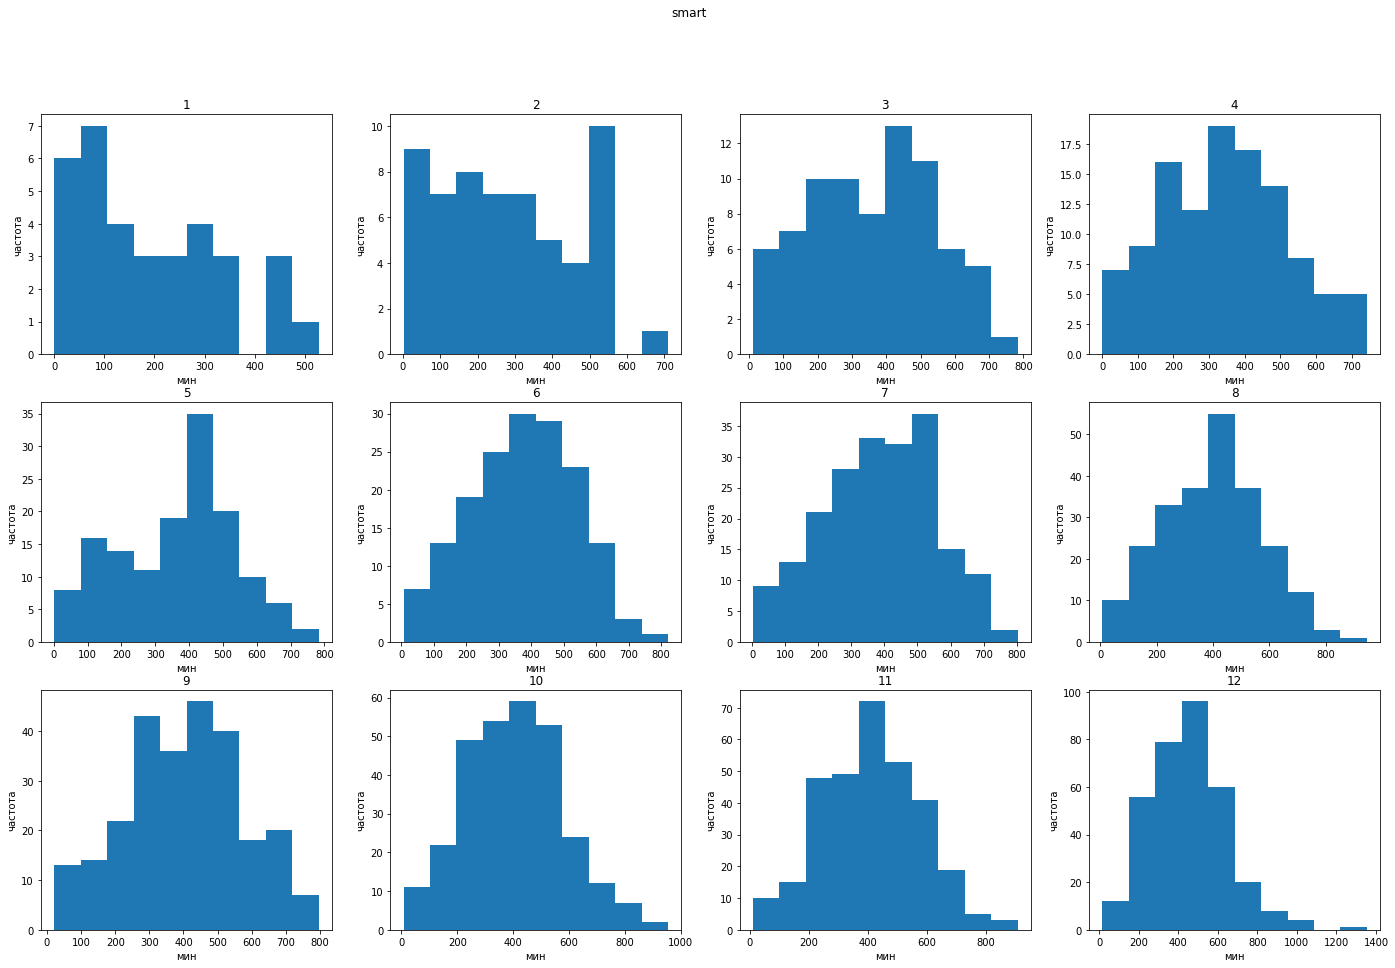

In [33]:
def subplot_hist(data, title, xlabel='x', ylabel='y'):
    plt.figure(figsize=(24, 15))
    
    for i in range(1, 13):
        plt.subplot(3,4,i)
        plt.hist(data[i])
        plt.title(i)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    plt.suptitle(title)
subplot_hist(calls_sum_s, title='smart', xlabel='мин', ylabel='частота')

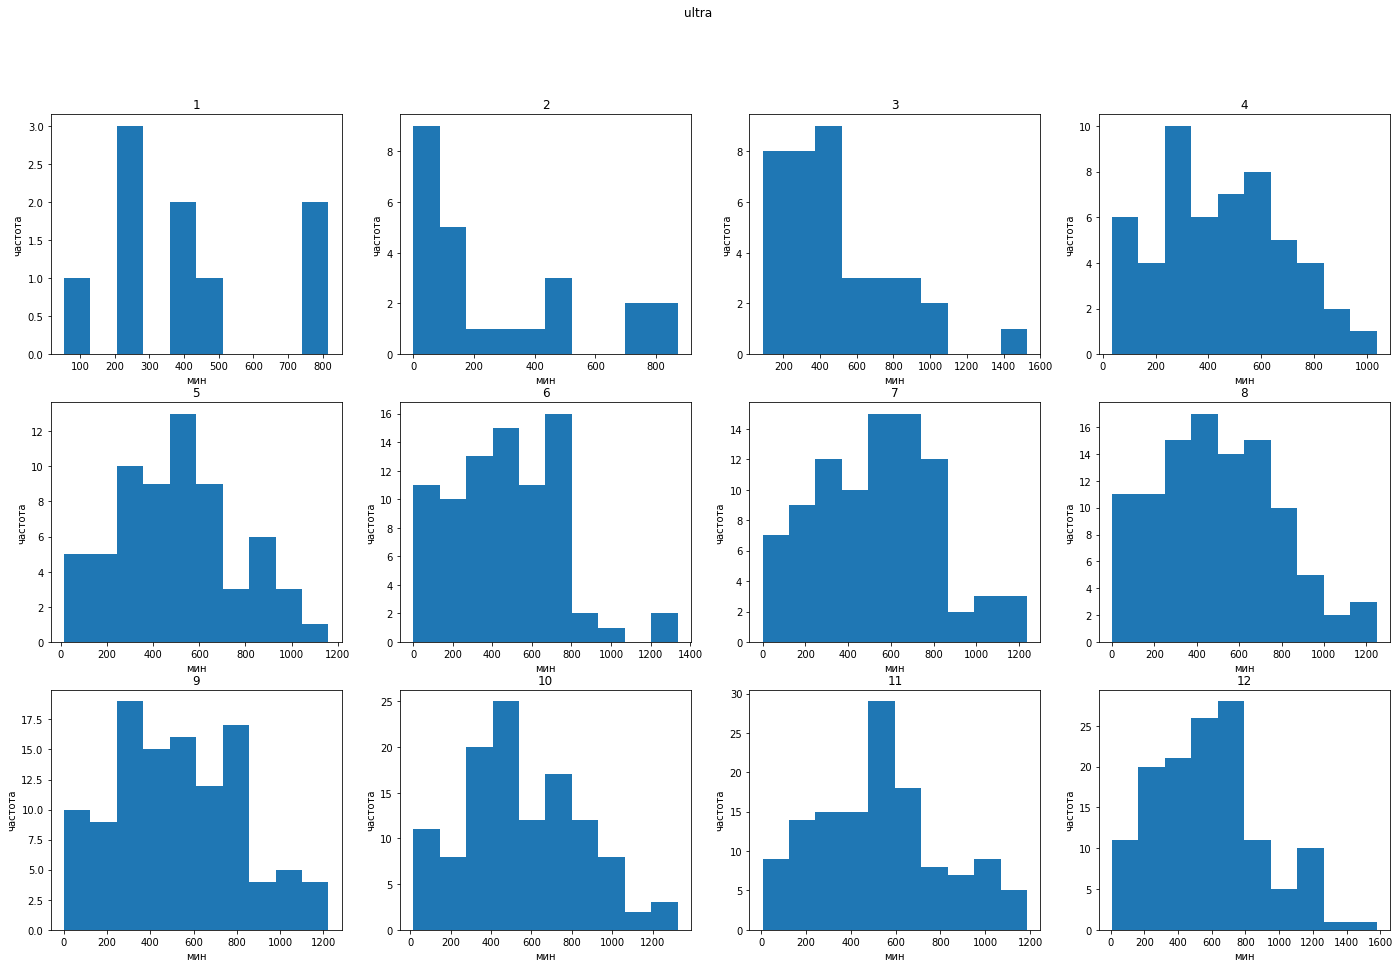

In [34]:
subplot_hist(calls_sum_u, title='ultra', xlabel='мин', ylabel='частота')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06b9315110>,
      dtype=object)

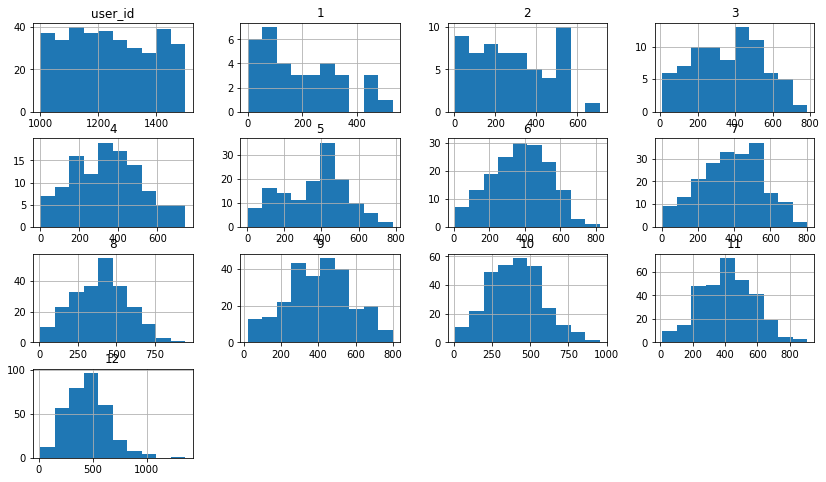

In [35]:
calls_sum_s.hist(figsize=(14,8))

На гистограммах видны провалы в превом полугодии, но с увеличением кол-ва клиентов гистограммы приобретают более нормальное распределение, особенно это заметно на гистограммах smart. Так же с увеличением клиентов, увеличиваются максимальные значения потраченных минут в обоих тарифах. При этом в тарифе smart к декабрю почти половина пользователей превышает лимит минут, а в ultra ни один пользователь за все время не привысил тарифа.

### Анализ трафика

Разделим данные по тарифам

In [36]:
internet_sum_u = internet_sum[internet_sum['tariff'] == 'ultra']
internet_sum_s = internet_sum[internet_sum['tariff'] == 'smart']

Найдем среднее, дисперсию и среднее отклонения для интернета тарифа smart

In [37]:
internet_decs_s = internet_sum_s.agg([np.mean, np.var, np.std])
internet_decs_s.drop('user_id', axis=1, inplace=True)
internet_decs_s

,1,2,3,4,5,6,7,8,9,10,11,12
mean,8.735294,11.844828,15.233766,13.62500,15.907801,15.951220,15.875622,16.807692,16.392308,16.880952,17.000000,18.201780
var,39.412656,37.150938,32.549897,31.29955,34.370010,31.911716,33.419453,28.962859,25.884110,32.897042,27.180952,29.786544
std,6.277950,6.095157,5.705252,5.59460,5.862594,5.649046,5.780956,5.381715,5.087643,5.735594,5.213535,5.457705


Найдем среднее, дисперсию и среднее отклонения для интернета тарифа ultra

In [38]:
internet_decs_u = internet_sum_u.agg([np.mean, np.var, np.std])
internet_decs_u.drop('user_id', axis=1, inplace=True)
internet_decs_u

,1,2,3,4,5,6,7,8,9,10,11,12
mean,13.222222,13.090909,17.648649,16.963636,19.666667,19.168675,20.733333,19.783019,19.412281,20.229508,19.954887,21.898551
var,44.444444,104.562771,114.345345,89.443098,91.241026,78.971202,92.737079,102.457233,83.713476,88.657634,91.513101,100.515180
std,6.666667,10.225594,10.693238,9.457436,9.552017,8.886574,9.630009,10.122116,9.149507,9.415818,9.566248,10.025726


С трафиком таже история что и со звонками. Пользователи обоих тарифоф используют в среднем около 20 гб, это означает что пользователи тарифа smart часто привышают фиксированный трафик, а пользователи ultra в основном остаются в пределах фиксированого значения. Стандартное отклонение так же больше в тарифе ultra, что указывает на больший разброс данных.

Построим гистограмы по месяцам для каждого тарифа

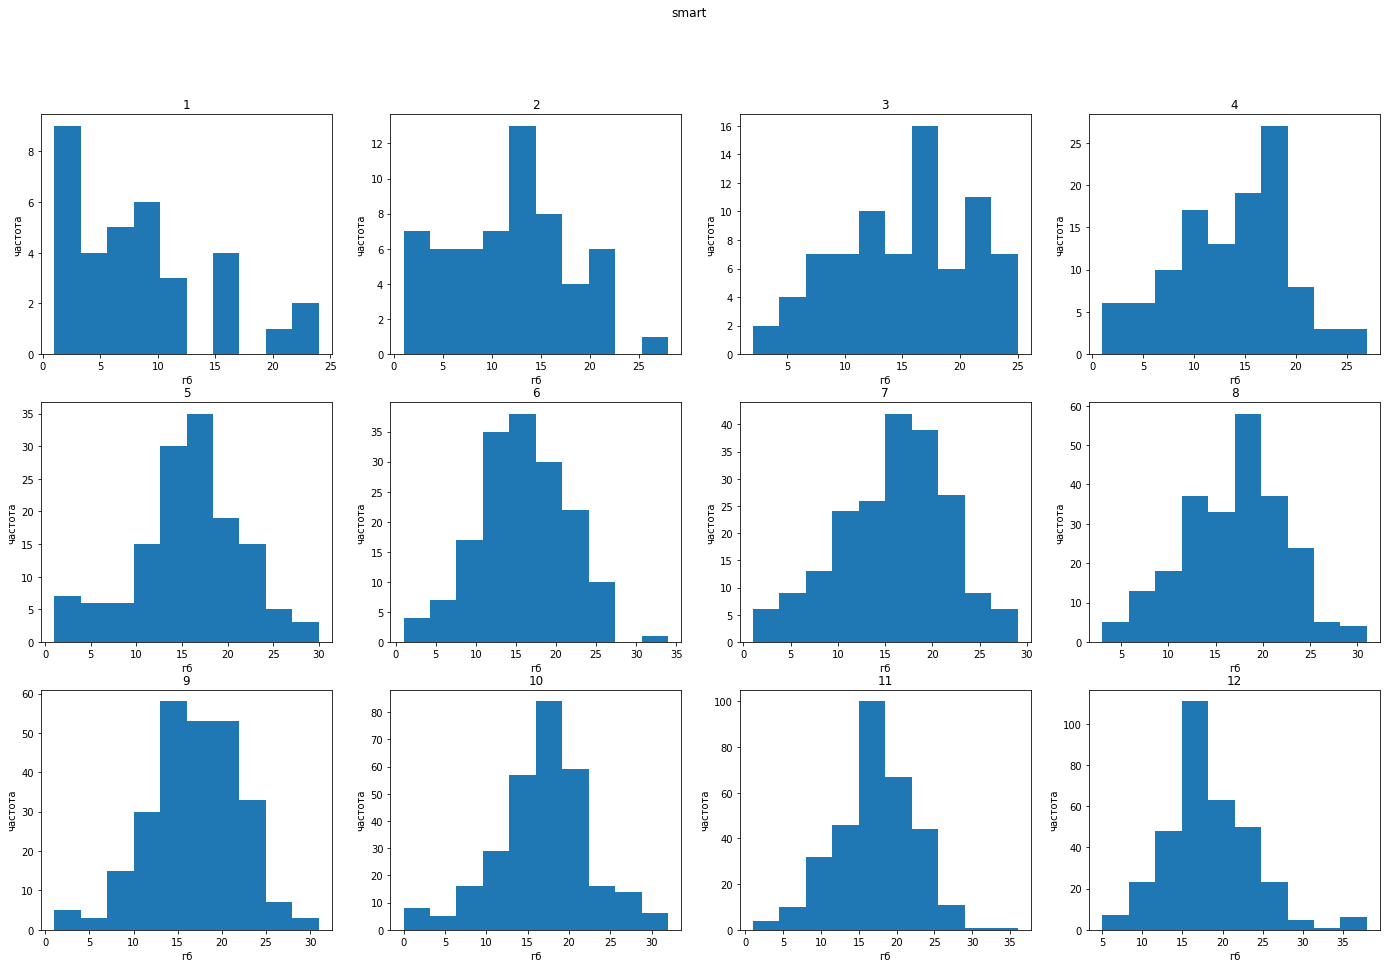

In [39]:
subplot_hist(internet_sum_s, title='smart', xlabel='гб', ylabel='частота')

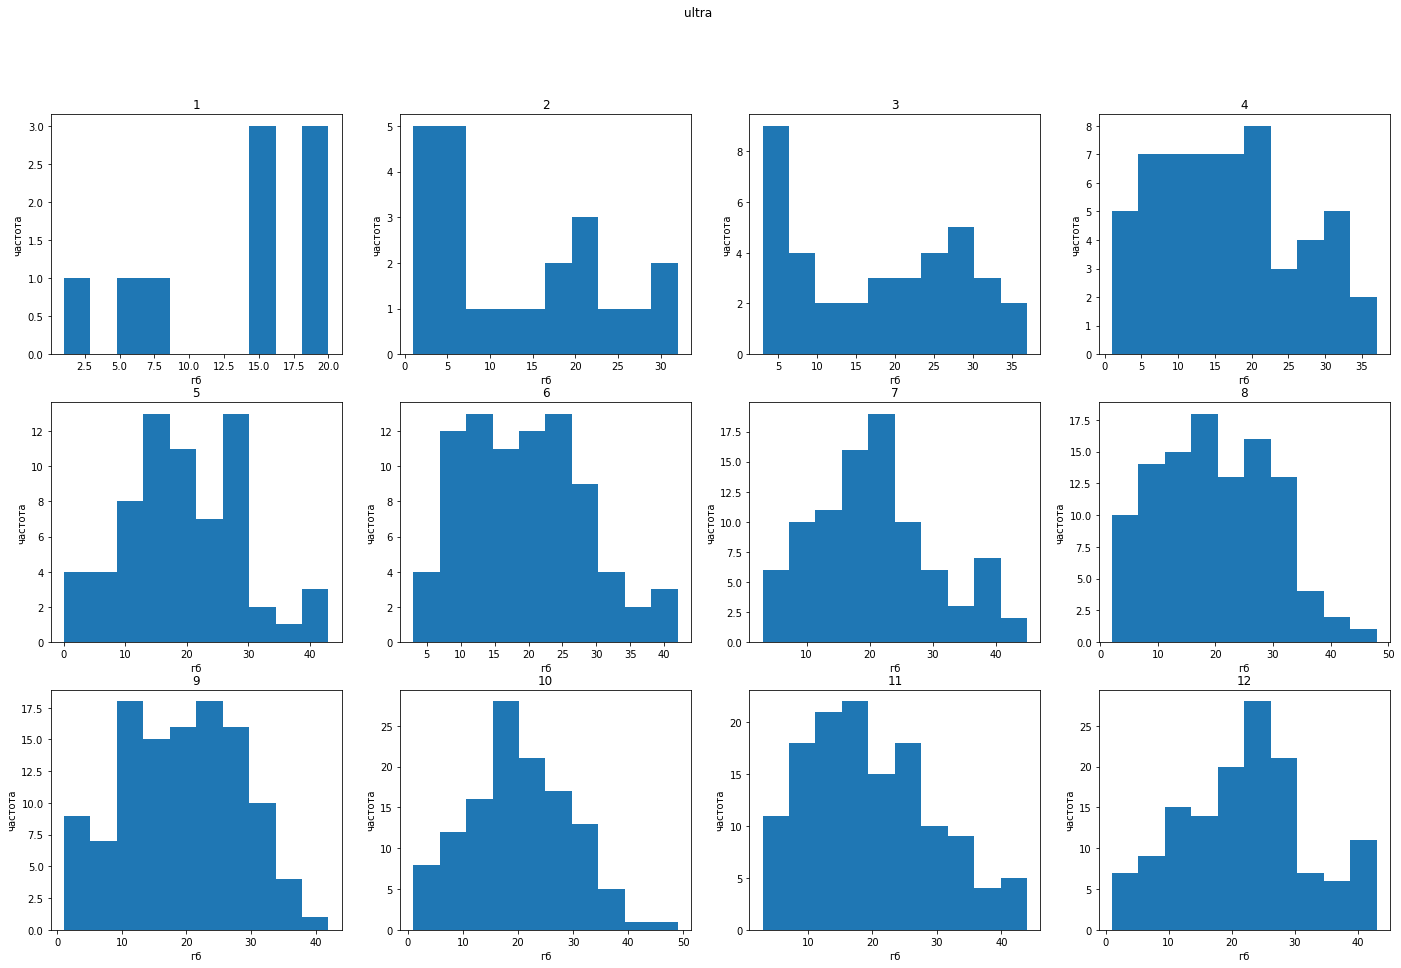

In [40]:
subplot_hist(internet_sum_u, title='ultra', xlabel='гб', ylabel='частота')

По гистограммам тарифа smart можно сказать, что большинсво позьзователей тарифа превышают трафик, это очень выгодно компании т.к. стоимость доп.трафика давольно существенная, а на гистограммах со временем положительная тенденция к росту дополнительного трафика. В гистограммах тарифа ultra такой тенденции нет, но появились клиенты превышающие фиксированный трафик. Распределение в гистограммах smart стремится к нормальному, в то время как в ultra остаются выбросы, которые скорее всего вызваны более сильным разбросом данных.

### Анализ сообщений

Разделим данные по тарифам

In [41]:
messages_sum_u = messages_count[messages_count['tariff'] == 'ultra']
messages_sum_s = messages_count[messages_count['tariff'] == 'smart']

Найдем среднее, дисперсию и среднее отклонения для сообщений тарифа smart

In [42]:
messages_decs_s = messages_sum_s.agg([np.mean, np.var, np.std])
messages_decs_s.drop('user_id', axis=1, inplace=True)
messages_decs_s

,1,2,3,4,5,6,7,8,9,10,11,12
mean,20.000000,27.940000,35.550725,35.864583,39.032787,38.577465,38.988506,38.750000,39.219731,39.082677,39.881481,42.264808
var,252.133333,440.465714,669.780477,517.865680,638.775776,731.635801,719.352468,767.213054,702.505555,736.503019,711.361366,832.447114
std,15.878707,20.987275,25.880117,22.756662,25.274014,27.048767,26.820747,27.698611,26.504821,27.138589,26.671359,28.852160


Найдем среднее, дисперсию и среднее отклонения для сообщений тарифа ultra

In [43]:
messages_decs_u = messages_sum_u.agg([np.mean, np.var, np.std])
messages_decs_u.drop('user_id', axis=1, inplace=True)
messages_decs_u

,1,2,3,4,5,6,7,8,9,10,11,12
mean,43.428571,32.937500,47.800000,44.512821,48.769231,52.313433,62.136986,58.897727,63.294737,69.776699,66.159292,72.008547
var,765.285714,713.395833,1826.666667,1408.256410,1559.553544,1935.672999,2190.730974,2022.966432,1906.763270,2426.606511,2249.295828,2362.870616
std,27.663798,26.709471,42.739521,37.526743,39.491183,43.996284,46.805245,44.977399,43.666501,49.260598,47.426742,48.609368


В сообщениях картина меняется, и различия между средними двух тарифов становятся более значимыми. Пользователи тарифа smart
в сренем укладываются в 50 сообщений, но со временем значение стремится вверх, а остаток фиксированных сообщений сокращается. Пользователи ultra не успевают потратить свои сообщения и тратят в среднем в 14 раз меньше значения устаноного тарифом! Стандартное отклонение так же сильно больше в тарифе ultra, что не удивительно при такой свободе 'размаха' в сообщениях.

Построим гистограмы по месяцам для каждого тарифа

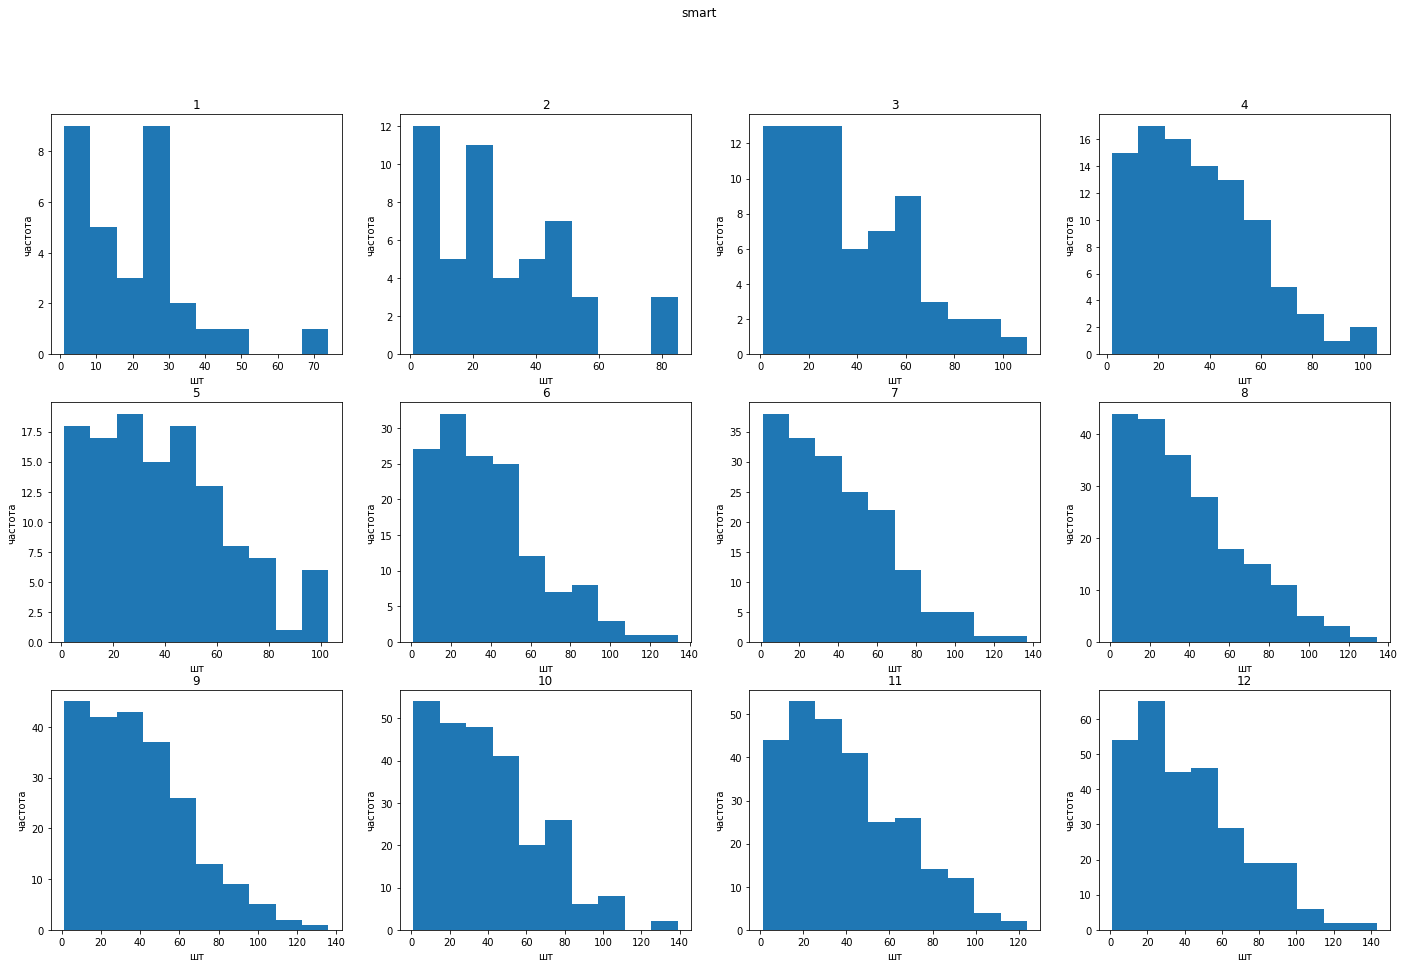

In [44]:
subplot_hist(messages_sum_s, title='smart', xlabel='шт', ylabel='частота')

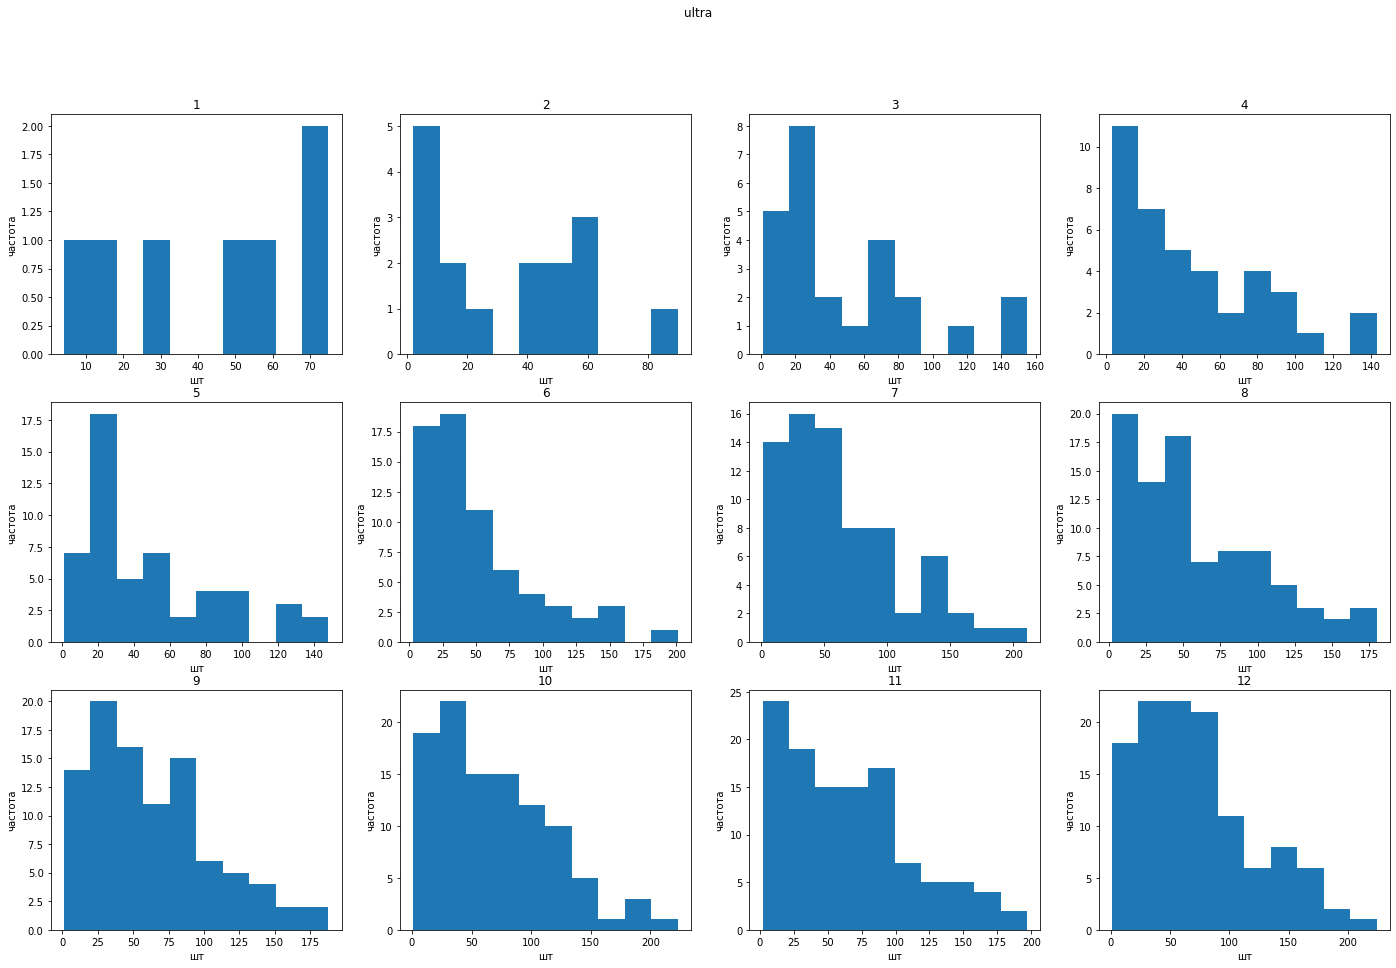

In [45]:
subplot_hist(messages_sum_u, title='ultra', xlabel='шт', ylabel='частота')

В этот раз мы видим гистограммы смещенные в лево, что означает наличие большой части клиентов отправляющих мало сообщений, так же мы видим что большинсво значений заканчиваются на определенных значениях(smart- 60шт ultra- 100шт), после чего тянется длинный хвост. Мы видим что часть пользователей в тарифе smart превышают лимит - максимум на 90 шт, что приносит примерно 270 рублей - это менее выгодно чем лишний трафик или звонки. А у пользователей ultra остается огромный запас сообщений. 

### Вывод

Проанализировав данные можно сказать, что в среднем пользователи используют схожое колл-во трафика и минут, а вот сообщений больше отправляют пользователи ultra. Пользователи тарифа smart в среднем превышают фиксированные показатели тарифа, особенно это заметно на трафике и звонках. Из за привышения показателей, размер выручки часто увеличивается в несколько раз. При этом наблюдается тенденция к увеличению размера дополнительных минут, сообщений и гигабайт. А в тарифе ultra, наоборот, в звонках и сообщениях есть огромный запас, в трафике есть часть клиентов превышающих показатели, но тенденции к росту нет.

## Проверка гипотез 

### Проверка первой гепотизы

Проверим гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформируем нулевую и альтернативную гипотезу:

H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются
H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Найдем p-значение для второго полугодия(т.к. в первом много пропущенных значений из за маленького кол-ва пользователей)

Критический уровень значимости укажем 1% т.к имеем выборку хорошего размера измеряемую сотнями и менее вероятно получить случайные результаты чем в маленькой выборке

In [46]:
from scipy import stats as st

for i in range(6, 13):
    x1 = all_p[all_p['tariff'] == 'smart'][i]
    x2 = all_p[all_p['tariff'] == 'ultra'][i]
    results = st.ttest_ind(x1, x2)
    alpha = 0.01
    print(i)
    print("------------------------------------------------")
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

6
------------------------------------------------
p-значение:  3.5988362781176138e-12
Отвергаем нулевую гипотезу
7
------------------------------------------------
p-значение:  1.328193900585348e-11
Отвергаем нулевую гипотезу
8
------------------------------------------------
p-значение:  5.651211062141756e-12
Отвергаем нулевую гипотезу
9
------------------------------------------------
p-значение:  4.0537300851265314e-15
Отвергаем нулевую гипотезу
10
------------------------------------------------
p-значение:  3.073702449707154e-11
Отвергаем нулевую гипотезу
11
------------------------------------------------
p-значение:  1.1503796329010822e-17
Отвергаем нулевую гипотезу
12
------------------------------------------------
p-значение:  1.2139076230877982e-08
Отвергаем нулевую гипотезу


По всем шести месяцам мы получили p-значение меньше 1%, а это значит что у нас есть основания отклонить нулевую гипотезу и предположить что средние значения выручек различаются.

Посмотрим на средние значения выручек по месяцам

In [47]:
all_p_mean = all_p.groupby('tariff').mean()
all_p_mean.drop('user_id', axis=1, inplace=True)
all_p_mean = all_p_mean.reset_index()
all_p_mean

,tariff,1,2,3,4,5,6,7,8,9,10,11,12
0,smart,69.674786,134.012678,248.887521,299.741738,470.910085,549.530997,682.872279,863.033561,900.506724,1114.765185,1177.560826,1473.572051
1,ultra,117.785235,318.120805,500.335570,738.926174,926.174497,1149.664430,1293.624161,1495.973154,1562.416107,1705.369128,1881.543624,2008.389262


Мы видим что средняя выручка выше у тарифа ultra, на первых месяцах выручки различаются в 2 раза, но к концу года разрыв сокращается до четверти, что скорее всего вызвано ростом дополнительных трат трафика

Посмотрим на сумму выручек по тарифам

In [48]:
all_p_sum = all_p.groupby('tariff').sum()
all_p_sum.drop('user_id', axis=1, inplace=True)
all_p_sum = all_p_sum.reset_index()
all_p_sum

,tariff,1,2,3,4,5,6,7,8,9,10,11,12
0,smart,24455.85,47038.45,87359.52,105209.35,165289.44,192885.38,239688.17,302924.78,316077.86,391282.58,413323.85,517223.79
1,ultra,17550.00,47400.00,74550.00,110100.00,138000.00,171300.00,192750.00,222900.00,232800.00,254100.00,280350.00,299250.00


Мы видим что на старте тарифы шли примерно одинаково, но со второго полугодия разрыв начал увеличиватся, а к концу года выручка с тарифа smart стала почти в два раза больше. Это может быть связано с увеличением чила пользователей тарифа smart и его средней выручки

Посмотрим на кол-во пользователей

In [49]:
users.groupby('tariff')['user_id'].count()

tariff
smart    351
ultra    149
Name: user_id, dtype: int64

Мы видим что пользователей тарифа smart более чем в 2 раза больше пользователей ultra.
Это означает, что если выборка случайная и репрезентативная, то соотношение выборки отражает соотношение ГС и говорит о том, что несмотря на то что среднее значение выручек выше у тарифа ultra, при большем соотношении в сторону тарифа smart он являеется более прибыльным для компании 

### Проверка второй гепотизы

Проверим гепотизу о том, что средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов

Сформируем нулевую и альтернативную гипотезу:

H0 - средняя выручка пользователи из Москвы не отличается от выручки пользователей из других регионов

H1 - средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов

Добавим в таблицу данные о городе

In [50]:
all_p = all_p.merge(users[['user_id', 'city']], on='user_id', how='left')
all_p

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,city
0,1000.0,0.0,0.00,0.00,0.0,1950.0,1950.00,1950.00,1950.0,1950.0,1950.0,1950.00,1950.00,ultra,Краснодар
1,1001.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,1150.00,550.00,smart,Москва
2,1002.0,0.0,0.00,0.00,0.0,0.0,550.00,1150.00,1550.0,950.0,550.0,1350.00,1150.00,smart,Стерлитамак
3,1003.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,1950.0,1950.0,1950.0,1950.00,1950.00,ultra,Москва
4,1004.0,0.0,0.00,0.00,0.0,1950.0,1950.00,1950.00,1950.0,1950.0,1950.0,1950.00,1950.00,ultra,Новокузнецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,1950.0,2400.0,1950.0,3300.00,1950.00,ultra,Иркутск
496,1496.0,550.0,3334.23,2615.85,1750.0,2350.0,1637.63,2500.18,2150.0,2950.0,3150.0,2949.66,1753.00,smart,Вологда
497,1497.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,550.0,550.00,1595.99,smart,Челябинск
498,1498.0,0.0,0.00,0.00,0.0,0.0,0.00,550.00,2386.0,1950.0,1750.0,0.00,0.00,smart,Владикавказ


Найдем p-значение так же только для второго полугодия

Критический уровень значимости укажем так же 1%

In [51]:
for i in range(6, 13):
    x1 = all_p[all_p['city'] == 'Москва'][i]
    x2 = all_p[all_p['city'] != 'Москва'][i]
    results = st.ttest_ind(x1, x2)
    alpha = 0.01
    print(i)
    print("------------------------------------------------")
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

6
------------------------------------------------
p-значение:  0.7702325151310205
Не получилось отвергнуть нулевую гипотезу
7
------------------------------------------------
p-значение:  0.5089647658285736
Не получилось отвергнуть нулевую гипотезу
8
------------------------------------------------
p-значение:  0.47523759098208784
Не получилось отвергнуть нулевую гипотезу
9
------------------------------------------------
p-значение:  0.5358533808560144
Не получилось отвергнуть нулевую гипотезу
10
------------------------------------------------
p-значение:  0.6228200168256217
Не получилось отвергнуть нулевую гипотезу
11
------------------------------------------------
p-значение:  0.6128241217544332
Не получилось отвергнуть нулевую гипотезу
12
------------------------------------------------
p-значение:  0.4625561405104518
Не получилось отвергнуть нулевую гипотезу


Мы видим p-значение по второму полугодию около 0.5, что говорит нам о вероятности около 50% получить такие или более выраженные различия случайно и нет оснований для отвержения нулевой гипотезы. Это дает нам основания предположить что выручки в Москве и регионах не отличаются.

Взглянем на среднее в Москве и регионах

In [52]:
all_p[all_p['city'] == 'Москва'].mean()

user_id    1256.717172
1           119.191919
2           165.288485
3           329.899192
4           436.793939
5           573.986566
6           704.597071
7           808.738788
8           989.827980
9          1048.236162
10         1249.620707
11         1427.081010
12         1568.450606
dtype: float64

In [53]:
all_p[all_p['city'] != 'Москва'].mean()

user_id    1247.718204
1            75.326309
2           194.700474
3           322.317955
4           429.094140
5           614.625362
6           734.240075
7           878.735736
8          1066.912244
9          1109.981247
10         1300.923017
11         1377.538229
12         1648.870773
dtype: float64

Мы видим что в начале есть небольшое различие, но к концу года оно почти уходит на нет.

### Вывод

Мы проверили две гипотезы и получили основания полагать, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются, а средняя выручка пользователи из Москвы не отличается от выручки пользователей из других регионов. Так же мы выяснили у тарифа smart есть тенденция к росту выручки и он понемногу сравнивается с тарифом ultra, а так же пользователей smart более чем в 2 раза больше.

## Общий вывод

В исследовании мы предобработали данные и добавили в новые для дальнейшего анализа. По результатам анализа мы выяснили, что в среднем пользователи используют близкие значения трафика и минут, а вот сообщений пишут больше пользователи тарифа ultra. При этом пользователи тарифа smart часто превышают показатели тарифа - увеличивая выручку в разы. Так же у тарифа smart наблюдается тенденция к росту трат, в отличии от ultra в котором в сообщения и минутах остается огромный запас, который еще не 'покорил' не один пользователь. Так же мы проверили гипотезы о различии выручек в зависимости от тарифов и различии выручки в Москве и регионах, по результатом которых мы получили основания полагать, что среднии выручки в зависимости от тарифа отличаются, а в зависимости от региона нет. 

Все результате исследования, мы имеем основания предположить что тариф «Смарт» более выгодный для компании на момент исследования за счет большего объема пользователей, но в перспективе большую часть рекламного бюджета лучше вложить в тариф «Ультра» т.к. у него больше средняя выручка, а это потенциальное увеличение общей прибыли. Часть бюджета стоит вложить и в «Смарт» т.к. у него есть перспективы для дальнейшего роста выручки за счет увеличения затрат пользователей. Также бюджет для Москвы и регионов можно распределить поровну из за отсутствия различий в выручках.